In [116]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from kerastuner.tuners import GridSearch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
import lime
import lime.lime_tabular

In [117]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
%cd '/content/drive/My Drive/MLB/'

/content/drive/.shortcut-targets-by-id/1PalnQoqxwKSNmjwwhhe0BhrD5i7LDjCp/MLB


In [119]:
!pip install -q -U keras-tuner

In [120]:
df_vars_encoded = pd.read_csv('NHIS_onehot_data.csv')

In [121]:
df_vars_encoded.head()

,HEIGHTTC_A,SLPHOURS_A,LSATIS4_A,MARITAL_A_1,MARITAL_A_2,MARITAL_A_3,HICOV_A_1,HICOV_A_2,EMPLASTWK_A_1,EMPLASTWK_A_2,...,BMICAT_A_3,BMICAT_A_4,REGION_1,REGION_2,REGION_3,REGION_4,URBRRL_1,URBRRL_2,URBRRL_3,URBRRL_4
0,74,8,2,1,0,0,1,0,1,0,...,0,1,0,0,1,0,0,0,0,1
1,64,8,1,0,1,0,1,0,0,1,...,0,1,0,0,1,0,0,0,0,1
2,66,8,2,0,0,1,1,0,0,1,...,1,0,0,0,1,0,1,0,0,0
3,69,8,1,1,0,0,1,0,0,1,...,0,0,0,0,1,0,1,0,0,0
4,71,10,1,0,0,1,1,0,0,1,...,1,0,0,0,1,0,1,0,0,0


In [122]:
X = df_vars_encoded.drop('LSATIS4_A', axis=1)
y = df_vars_encoded['LSATIS4_A']

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [124]:
# build an MLP with one hidden layer. Use kerastuner GridSearch to perform hyperparameter tuning on the model

def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units1', min_value=64, max_value=64, step=32),
                    activation='relu'))
    model.add(Dense(units=hp.Int('units2', min_value=16, max_value=128, step=16),
                    activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

tuner = GridSearch(
    build_model,
    objective='val_accuracy',
    max_trials=50,
    directory='hyperparameter_tuning',
    project_name='MLP_hyperparameter_tuning',
    overwrite=True
)

tuner.search(x=X_train, y=y_train, validation_data=(X_test, y_test))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps}")

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

Trial 24 Complete [00h 00m 03s]
val_accuracy: 0.583076000213623

Best val_accuracy So Far: 0.6547251343727112
Total elapsed time: 00h 01m 43s
Best hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7e448206f7c0>
Epoch 1/10
405/405 [==============================] - 2s 3ms/step - loss: 0.8350 - accuracy: 0.6144 - val_loss: 0.7374 - val_accuracy: 0.6343
Epoch 2/10
405/405 [==============================] - 1s 2ms/step - loss: 0.7438 - accuracy: 0.6384 - val_loss: 0.7209 - val_accuracy: 0.6433
Epoch 3/10
405/405 [==============================] - 1s 2ms/step - loss: 0.7363 - accuracy: 0.6450 - val_loss: 0.7571 - val_accuracy: 0.6396
Epoch 4/10
405/405 [==============================] - 1s 2ms/step - loss: 0.7306 - accuracy: 0.6491 - val_loss: 0.7196 - val_accuracy: 0.6448
Epoch 5/10
405/405 [==============================] - 1s 2ms/step - loss: 0.7316 - accuracy: 0.6481 - val_loss: 0.7278 - val_accuracy: 0.6485
Epoch 6/10
405/405 [========

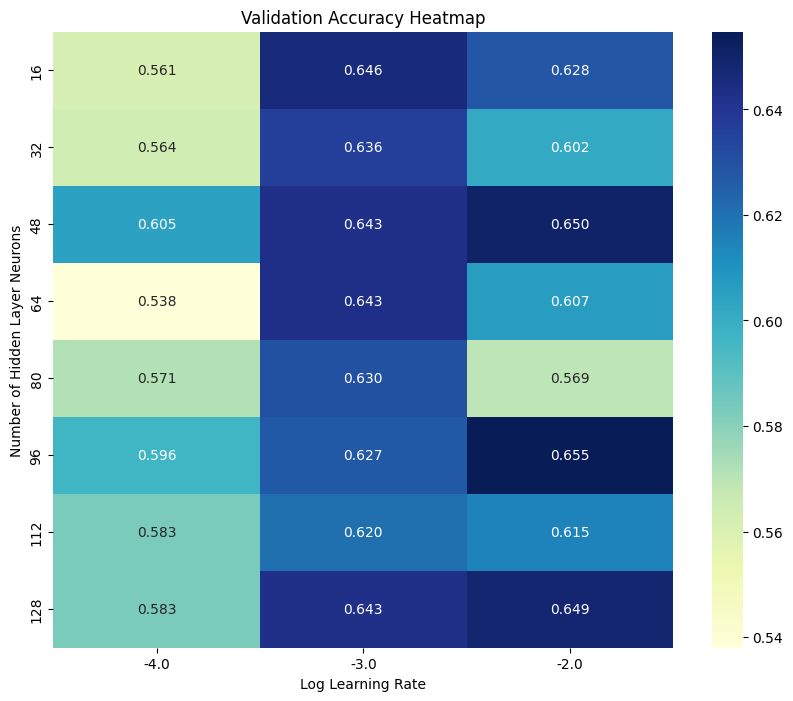

In [154]:
# plot the heatmap of the accuracy values obtained with the various learning rates and hidden layer neuron counts

trials = tuner.oracle.get_best_trials(num_trials=50)
hyperparameters = [trial.hyperparameters.values for trial in trials]
val_accuracies = [trial.metrics.get_best_value('val_accuracy') for trial in trials]

learning_rates = [np.log10(hp['learning_rate']) for hp in hyperparameters]
units1 = [hp['units1'] for hp in hyperparameters]
units2 = [hp['units2'] for hp in hyperparameters]

data = {
    'Log Learning Rate': learning_rates,
    'Number of Hidden Layer Neurons (units1)': units1,
    'Number of Hidden Layer Neurons (units2)': units2,
    'Validation Accuracy': val_accuracies
}
df = pd.DataFrame(data)

plt.figure(figsize=(10, 8))
sns.heatmap(df.pivot_table(index='Number of Hidden Layer Neurons (units2)', columns='Log Learning Rate', values='Validation Accuracy'), cmap='YlGnBu', annot=True, fmt=".3f")
plt.title('Validation Accuracy Heatmap')
plt.xlabel('Log Learning Rate')
plt.ylabel('Number of Hidden Layer Neurons')
plt.show()


In [126]:
# the best model and its hyperparameter values

best_hyperparameters = best_hps.values

print("Hyperparameters of the Best Model:")
for key, value in best_hyperparameters.items():
    print(f"{key}: {value}")

Hyperparameters of the Best Model:
units1: 64
units2: 96
learning_rate: 0.01


In [127]:
# obtain classification report

y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(y_test.shape)

report = classification_report(y_test, y_pred_classes)
print(report)

102/102 [==============================] - 0s 2ms/step
(3238,)
              precision    recall  f1-score   support

           1       0.65      0.71      0.68      1589
           2       0.64      0.61      0.62      1547
           3       0.25      0.09      0.13        81
           4       0.00      0.00      0.00        21

    accuracy                           0.64      3238
   macro avg       0.38      0.35      0.36      3238
weighted avg       0.63      0.64      0.63      3238



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [128]:
print(report)

              precision    recall  f1-score   support

           1       0.65      0.71      0.68      1589
           2       0.64      0.61      0.62      1547
           3       0.25      0.09      0.13        81
           4       0.00      0.00      0.00        21

    accuracy                           0.64      3238
   macro avg       0.38      0.35      0.36      3238
weighted avg       0.63      0.64      0.63      3238



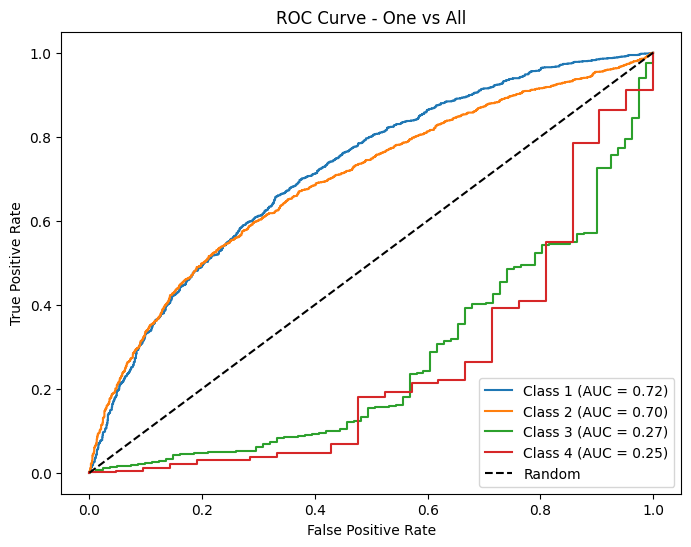

In [129]:
# obtain roc curve

y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    tpr[i], fpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])  # Corrected order of fpr and tpr
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')  # Adjusted label for class value

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One vs All')
plt.legend(loc='lower right')
plt.show()

In [130]:
!pip install lime

In [132]:
# obtain feature importance scores using LIME

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(), verbose=True, mode='classification')

feature_importances = {}
feature_counts = {}

sample_indices = np.random.choice(len(X_test), 500, replace=False)

for j in sample_indices:
    exp = explainer.explain_instance(X_test.values[j], best_model.predict, num_features=len(X_test.columns))
    for feature, weight in exp.as_list():
        if feature in feature_importances:
            feature_importances[feature] += abs(weight)
            feature_counts[feature] += 1
        else:
            feature_importances[feature] = abs(weight)
            feature_counts[feature] = 1

for feature in feature_importances:
    feature_importances[feature] /= feature_counts[feature]

top_20_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)[:20]

for feature, importance in top_20_features:
    print(f"Feature: {feature}, Importance: {importance}")

157/157 [==============================] - 0s 2ms/step
Intercept -0.4195503306011733
Prediction_local [0.65860747]
Right: 0.65431136
157/157 [==============================] - 0s 3ms/step
Intercept -0.02192684496560815
Prediction_local [0.29497291]
Right: 0.3877256
157/157 [==============================] - 1s 3ms/step
Intercept -0.12397823731271251
Prediction_local [0.5411288]
Right: 0.54176474
157/157 [==============================] - 0s 2ms/step
Intercept -0.1713793295768551
Prediction_local [0.46442161]
Right: 0.4836747
157/157 [==============================] - 0s 2ms/step
Intercept -0.46915453450747446
Prediction_local [0.79331032]
Right: 0.7781058
157/157 [==============================] - 1s 5ms/step
Intercept -0.3128139236651847
Prediction_local [0.56480957]
Right: 0.5433109
157/157 [==============================] - 1s 6ms/step
Intercept 0.15377092417794924
Prediction_local [0.22613179]
Right: 0.44579583
157/157 [==============================] - 0s 3ms/step
Intercept 0.3358

In [133]:
# Get the top 20 features after combining various bins of the same feature into a single feature

combined_feature_importances = {}
combined_feature_counts = {}

for feature, importance in feature_importances.items():
    base_feature = feature.split(' ')[0]
    if base_feature in combined_feature_importances:
        combined_feature_importances[base_feature] += importance
        combined_feature_counts[base_feature] += 1
    else:
        combined_feature_importances[base_feature] = importance
        combined_feature_counts[base_feature] = 1

for feature in combined_feature_importances:
    combined_feature_importances[feature] /= combined_feature_counts[feature]


top_20_combined_features = sorted(combined_feature_importances.items(), key=lambda x: x[1], reverse=True)[:20]

for feature, importance in top_20_combined_features:
    print(f"Combined Feature: {feature}, Importance: {importance}")

Combined Feature: PHSTAT_A_5, Importance: 0.18391372843561632
Combined Feature: PHSTAT_A_4, Importance: 0.17707693131144692
Combined Feature: PHSTAT_A_1, Importance: 0.1651311862415873
Combined Feature: RATCAT_A_2, Importance: 0.1040550644030202
Combined Feature: AGEP_A_83, Importance: 0.10080716357313044
Combined Feature: HISPALLP_A_4, Importance: 0.09977723402886456
Combined Feature: PHSTAT_A_3, Importance: 0.09799117600540236
Combined Feature: DEPEV_A_1, Importance: 0.09435230267335679
Combined Feature: AGEP_A_81, Importance: 0.09399904325275653
Combined Feature: RATCAT_A_4, Importance: 0.08480902543110008
Combined Feature: AGEP_A_71, Importance: 0.08426882166295695
Combined Feature: MARITAL_A_3, Importance: 0.08218568495700852
Combined Feature: MARITAL_A_1, Importance: 0.08095398383903628
Combined Feature: AGEP_A_28, Importance: 0.07513251186139702
Combined Feature: RATCAT_A_14, Importance: 0.07475349792433045
Combined Feature: AGEP_A_79, Importance: 0.07471160104197033
Combined Fe

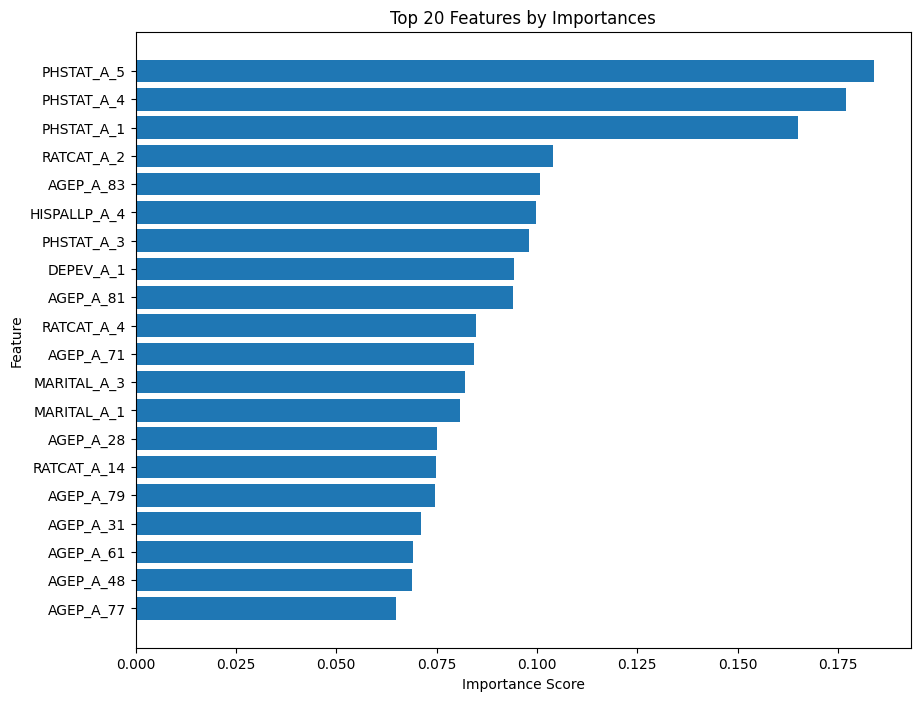

In [134]:
top_20_combined_features = sorted(combined_feature_importances.items(), key=lambda x: x[1], reverse=True)[:20]


features = [feature for feature, _ in top_20_combined_features]
importances = [importance for _, importance in top_20_combined_features]

plt.figure(figsize=(10, 8))
plt.barh(features, importances)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 20 Features by Importances')
plt.gca().invert_yaxis()
plt.show()